# Capítulo 1
Introdução ao PyTorch e ao dataset CIFAR-10. De prefencia algumas plotagens das imagens desse dataset.

# Treinando um classificador de imagem
1. Carregue e normalize os conjuntos de dados de treinamento e teste CIFAR10 usando *torchvision*
2. Definir uma rede neural convulacional
3. Definir uma loss function
4. Treinar a rede com os dados de treinamento
5. Teste a rede com os dados de teste

In [1]:
# Carregando as bibliotecas que serão usadas

import torch # Usado para construir e treinar redes neurais.
import torch.nn as nn
import torch.optim as optim
import torchvision # Possui utilitários para processamento de dados, como datasets e modelos pré-treinados.
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt # Para plotar gráficos e visualizar resultados.
import numpy as np
from tqdm import tqdm # biblioteca para mostrar progresso de looping

In [2]:
# Verifica se uma GPU está disponível
if torch.cuda.is_available():
    device = torch.device("cuda")  # Usar GPU
    print("Usando GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Usar CPU
    print("Usando CPU")

Usando CPU


In [3]:
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
batch_size_train = 500
batch_size_test = 100

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #expande e realiza um corte na imagem
    transforms.RandomHorizontalFlip(), # Realiza um flip horizontal aleatório na imagem (espelhamento em torno do eixo vertical).
    transforms.ToTensor(), # converte as imagens em tensores
    transforms.Normalize(mean, std) # normaliza os dados
])

transform_test = transforms.Compose([
    transforms.ToTensor(), # converte as imagens em tensores
    transforms.Normalize(mean, std) # normaliza os dados
])

# carregando os dados de treino
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size_train, shuffle=True, num_workers=2)

# carregando os dados de teste
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size_test, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Explicação:

São usados parametros diferentes no transforms, pois o **treino** do modelo tem a necessidade de ver variações diferentes das imagens para não criar um hábito de vício durante o treinamento, já o **teste**, recebe parametros iguais para estabilizar e dar precisão ao modelo.

Primeiras 16 imagens


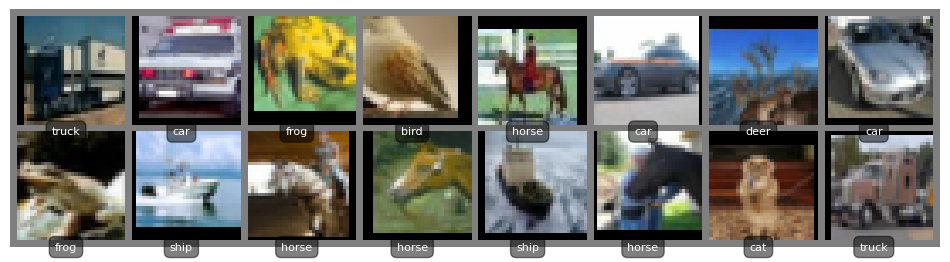

In [4]:
def mostrar_imagens_com_rotulos(imgs, labels):
    imgs = (imgs * 0.5) + 0.5  # Desnormalizar (reverter a normalização)
    npimg = imgs.numpy()  # converter tensor para numpy

    plt.figure(figsize=(12, 12))  # amplia as imagens
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpor para formato HWC
    plt.axis('off')  # tira as marcações de eixos

    # Obter o número de imagens por linha e altura de cada imagem
    num_imgs = len(labels)
    img_size = 32  # Tamanho de cada imagem (CIFAR-10 tem 32x32 pixels)
    padding = 2  # Padding utilizado pelo make_grid para separar as imagens

    for i in range(num_imgs):
        # Posição do texto na imagem, considerando a faixa cinza
        plt.text((i % 8) * (img_size + padding) + img_size // 2, 
                 (i // 8) * (img_size + padding) + img_size + 5,  # Posiciona um pouco acima da parte inferior
                 classes[labels[i]], color='white', fontsize=8, ha='center', va='bottom', 
                 bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.5'))

    plt.show()

# Obtendo imagens de treinamento aleatórias
dataiter = iter(trainloader)  # iterador para o DataLoader
images, labels = next(dataiter)  # obter um batch de imagens e rótulos

# Definir as classes do CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Selecionando as primeiras 16 imagens
images_16 = images[:16]
labels_16 = labels[:16]

# Mostrar imagens com rótulos diretamente
print('Primeiras 16 imagens')
mostrar_imagens_com_rotulos(torchvision.utils.make_grid(images_16, nrow=8), labels_16)



In [5]:
#model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) #ResNet18
model = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2) #Resnet152
model.fc = nn.Linear(model.fc.in_features, 10) # Modifica a última camada para 10 classes (CIFAR-10)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\andre/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 82.9MB/s] 


Explicação:
* ResNet18: Uma rede neural profunda com blocos de camadas residuais que ajudam a lidar com problemas de degradação em redes muito profundas.
* model.fc: Ajustamos a última camada (fully connected) para que a rede produza 10 saídas, correspondentes às 10 classes do CIFAR-10.

In [6]:
criterion = nn.CrossEntropyLoss() # loss funciton
optimizer = optim.Adam(model.parameters(), lr=0.001) # modelo otimizador

Explicação:
* CrossEntropyLoss: Calcula a diferença entre as predições do modelo e as classes reais. Essa função é ideal para problemas de classificação multiclasses.
* Adam Optimizer: Atualiza os pesos da rede de forma eficiente, adaptando-se às mudanças na função de perda.

In [7]:
epochs = 1 # número de épocas (quantas vezes o modelo verá o conjunto de treino)

train_losses = []
for epoch in range(epochs):
  model.train() # coloca o modelo em modo de treinamento
  running_loss = 0.0

  for inputs, labels in tqdm(trainloader):

    optimizer.zero_grad() # zera os gradientes acumulados
    outputs = model(inputs) # foward pass: obtem as predições
    loss = criterion(outputs, labels) # calcula a perda
    loss.backward() # backward pass: calcula os gradientes
    optimizer.step() # atualiza os pesos

    running_loss += loss.item() # acumula a perda

  epoch_loss = running_loss / len(trainloader)
  train_losses.append(epoch_loss)
  print(f'Epoch [{epoch + 1} / {epochs}], Loss: {epoch_loss:.4f}')

  1%|          | 1/100 [00:40<1:06:05, 40.06s/it]


KeyboardInterrupt: 

Explicação:
* num_epochs: Número de épocas define quantas vezes o modelo verá todo o dataset de treinamento.
* model.train(): Coloca o modelo no modo de treinamento, permitindo que os gradientes sejam calculados e os pesos atualizados.
* optimizer.zero_grad(): Zera os gradientes antes de cada iteração, para que eles não sejam acumulados.
* outputs = model(inputs): Passa as imagens através da rede para gerar predições.
* loss.backward(): Calcula os gradientes da função de perda em relação aos pesos.
* optimizer.step(): Atualiza os pesos da rede com base nos gradientes calculados.

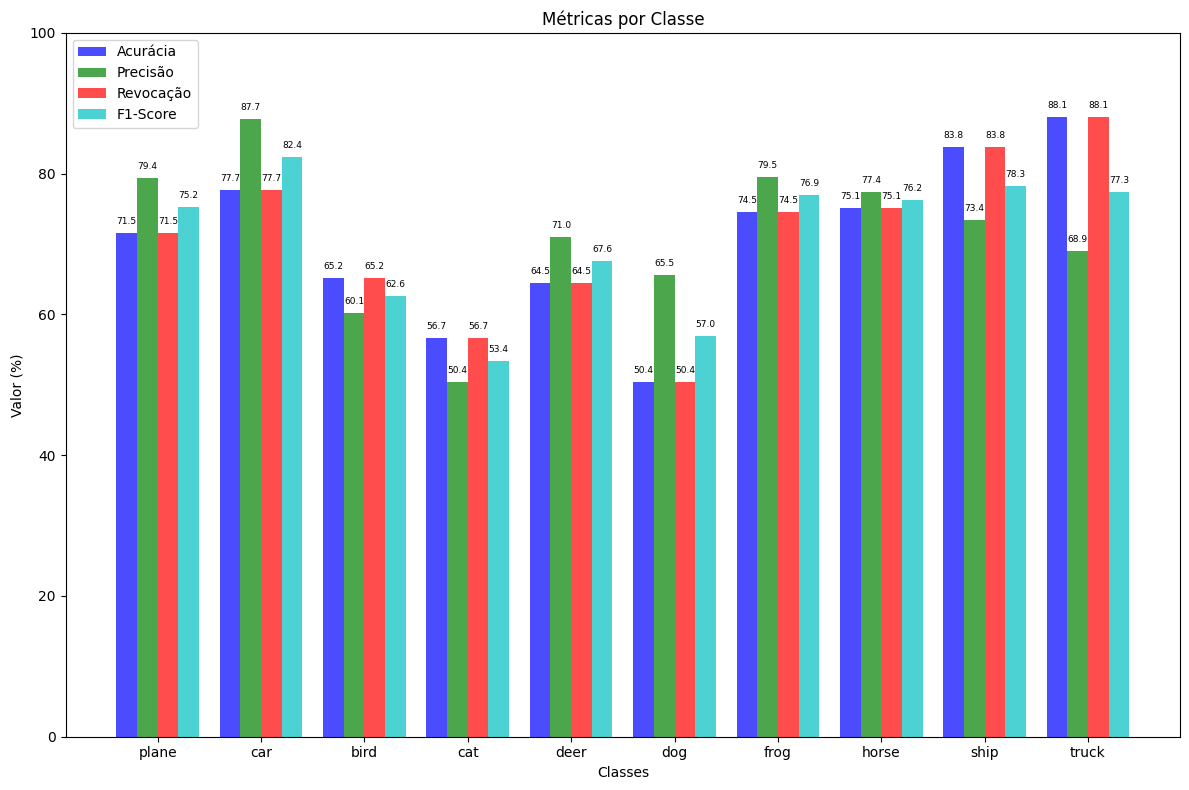

In [37]:
# Prepara contador de previsões para cada classe
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
false_pred = {classname: 0 for classname in classes}  # Contador de falsos positivos

with torch.no_grad():  # Desativa o cálculo de gradientes durante a avaliação
    for images, labels in testloader:
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        # Coletar as previsões corretas para cada classe
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
            # Contabiliza falsos positivos
            if label != prediction:
                false_pred[classes[prediction]] += 1

# Inicializa listas para armazenar métricas
accuracies = []
precisions = []
recalls = []
f1_scores = []
class_names = []

# Cálculo das métricas e armazenamento para o gráfico
for classname in classes:
    correct_count = correct_pred[classname]
    accuracy = 100 * float(correct_count) / total_pred[classname]
    precision = 100 * float(correct_count) / (correct_count + false_pred[classname]) if (correct_count + false_pred[classname]) > 0 else 0
    recall = 100 * float(correct_count) / (total_pred[classname]) if total_pred[classname] > 0 else 0
    f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    class_names.append(classname)

# Criar gráfico de barras agrupadas
n_classes = len(classes)
x = np.arange(n_classes)  # Índices das classes
width = 0.2  # Largura das barras

plt.figure(figsize=(12, 8))

# Adiciona as barras para cada métrica
bars1 = plt.bar(x - 1.5 * width, accuracies, width, label='Acurácia', color='b', alpha=0.7)
bars2 = plt.bar(x - 0.5 * width, precisions, width, label='Precisão', color='g', alpha=0.7)
bars3 = plt.bar(x + 0.5 * width, recalls, width, label='Revocação', color='r', alpha=0.7)
bars4 = plt.bar(x + 1.5 * width, f1_scores, width, label='F1-Score', color='c', alpha=0.7)

# Adiciona os números acima das barras
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}', ha='center', va='bottom', fontsize=6.5)

# Configurações dos eixos
plt.xticks(x, class_names)
plt.ylim(0, 100)
plt.title('Métricas por Classe')
plt.xlabel('Classes')
plt.ylabel('Valor (%)')

# Adiciona a legenda
plt.legend()

# Mostra o gráfico
plt.tight_layout()
plt.show()

Explicação:
* model.eval(): Coloca o modelo em modo de avaliação, onde ele não precisa calcular gradientes.
* torch.no_grad(): Desativa o autograd (backpropagation) para economizar memória durante a avaliação.
* correct e total: Contam quantas previsões a rede acertou e qual o total de amostras avaliadas, respectivamente.

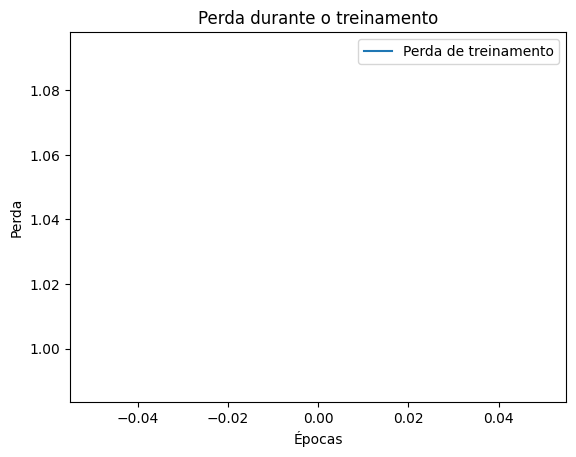

In [27]:
plt.plot(train_losses, label='Perda de treinamento')
plt.title('Perda durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()